In [1]:
from datasets import load_dataset,DatasetDict
from transformers import AutoTokenizer,AutoModelForSequenceClassification
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
DATA_PATH = "Hate Speech/labeled_data.csv"

In [3]:
pandas_df = pd.read_csv(DATA_PATH)
pandas_df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


<Axes: xlabel='class', ylabel='count'>

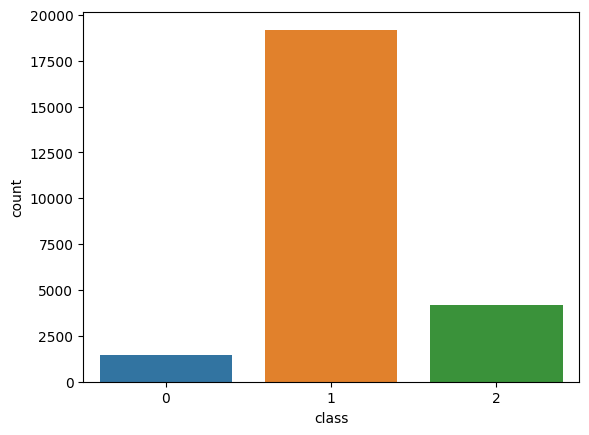

In [4]:
import seaborn as sns
sns.countplot(x=pandas_df['class'])

In [5]:
pandas_df['tweet_cleaned'] = pandas_df['tweet'].str.replace('@[A-Za-z0-9]+\s?', '', regex=True)
pandas_df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,tweet_cleaned
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,!!! RT : As a woman you shouldn't complain abo...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,!!!!! RT : boy dats cold...tyga dwn bad for cu...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,!!!!!!! RT Dawg!!!! RT : You ever fuck a bitch...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,!!!!!!!!! RT _G_Anderson: _based she look like...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,!!!!!!!!!!!!! RT : The shit you hear about me ...


In [6]:
from datasets import Dataset

ds = Dataset.from_pandas(pandas_df)
ds

Dataset({
    features: ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither', 'class', 'tweet', 'tweet_cleaned'],
    num_rows: 24783
})

In [7]:
train_test_valid = ds.train_test_split()

test_valid = train_test_valid['test'].train_test_split()

train_test_valid_dataset = DatasetDict({
    'train': train_test_valid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']
    })


dataset = train_test_valid_dataset.remove_columns(['hate_speech', 'offensive_language', 'neither','Unnamed: 0', 'count'])
dataset

DatasetDict({
    train: Dataset({
        features: ['class', 'tweet', 'tweet_cleaned'],
        num_rows: 18587
    })
    test: Dataset({
        features: ['class', 'tweet', 'tweet_cleaned'],
        num_rows: 1549
    })
    valid: Dataset({
        features: ['class', 'tweet', 'tweet_cleaned'],
        num_rows: 4647
    })
})

Tokenizer

In [8]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [9]:
text = "Just checking tokenization"

output = tokenizer(text)

output

{'input_ids': [101, 2066, 9444, 22559, 2734, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [10]:
tokens = tokenizer.convert_ids_to_tokens(output['input_ids'])
tokens

['[CLS]', 'Just', 'checking', 'token', '##ization', '[SEP]']

In [11]:
print(f"Tokenized text: {tokenizer.convert_tokens_to_string(tokens)}")

Tokenized text: [CLS] Just checking tokenization [SEP]


In [12]:
print(f"Vocab size is : {tokenizer.vocab_size}")

print(f"Model max length is : {tokenizer.model_max_length}")

print(f"Model input names are: {tokenizer.model_input_names}")

Vocab size is : 28996
Model max length is : 512
Model input names are: ['input_ids', 'token_type_ids', 'attention_mask']


In [13]:
tokenizer

BertTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [14]:
dataset

DatasetDict({
    train: Dataset({
        features: ['class', 'tweet', 'tweet_cleaned'],
        num_rows: 18587
    })
    test: Dataset({
        features: ['class', 'tweet', 'tweet_cleaned'],
        num_rows: 1549
    })
    valid: Dataset({
        features: ['class', 'tweet', 'tweet_cleaned'],
        num_rows: 4647
    })
})

In [15]:
def tokenize_function(train_dataset):
    return tokenizer(train_dataset['tweet_cleaned'], padding='max_length', truncation=True) 

tokenized_dataset = dataset.map(tokenize_function, batched=True)

tokenized_dataset
# train_dataset = tokenized_dataset['train']
# eval_dataset = tokenized_dataset['valid']
# test_dataset = tokenized_dataset['test']

Map:   0%|          | 0/18587 [00:00<?, ? examples/s]

Map:   0%|          | 0/1549 [00:00<?, ? examples/s]

Map:   0%|          | 0/4647 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['class', 'tweet', 'tweet_cleaned', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 18587
    })
    test: Dataset({
        features: ['class', 'tweet', 'tweet_cleaned', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1549
    })
    valid: Dataset({
        features: ['class', 'tweet', 'tweet_cleaned', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4647
    })
})

In [16]:
dataset["train"].features

{'class': Value(dtype='int64', id=None),
 'tweet': Value(dtype='string', id=None),
 'tweet_cleaned': Value(dtype='string', id=None)}

In [17]:
# train_dataset

In [18]:
tokenized_dataset["train"] = tokenized_dataset["train"].remove_columns(['tweet', "tweet_cleaned"])
tokenized_dataset["valid"] = tokenized_dataset["valid"].remove_columns(['tweet', "tweet_cleaned"])
tokenized_dataset["test"] = tokenized_dataset["test"].remove_columns(['tweet', "tweet_cleaned"])


In [19]:
tokenized_dataset["train"] = tokenized_dataset["train"].rename_column("class","label")
tokenized_dataset["valid"] = tokenized_dataset["valid"].rename_column("class","label")
tokenized_dataset["test"] = tokenized_dataset["test"].rename_column("class","label")

In [20]:
# tokenized_dataset["train"] = tokenized_dataset["train"].with_format("torch")
# tokenized_dataset["valid"] = tokenized_dataset["valid"].with_format("torch")
# tokenized_dataset["test"] = tokenized_dataset["test"].with_format("torch")


In [21]:
# tokenized_dataset["train"]["label"].isnan().any()

In [22]:
# train_set = train_dataset.remove_columns(['tweet', "tweet_cleaned"])

# tf_eval_dataset = eval_dataset.remove_columns(['tweet', "tweet_cleaned"])

# tf_test_dataset = test_dataset.remove_columns(['tweet', "tweet_cleaned"])

In [23]:
# train_set

In [24]:
model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased',num_labels=3)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initi

In [25]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [26]:
# train_features = { x: train_set[x] for x in tokenizer.model_input_names }

In [27]:
tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

In [28]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [29]:
data_collator

DataCollatorForTokenClassification(tokenizer=BertTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True), padding=True, max_length=None, pad_to_multiple_of=None, label_pad_token_id=-100, return_tensors='pt')

In [30]:
# train_batch = data_collator(train_set)

In [31]:
# train_batch

In [32]:
from transformers import TrainingArguments
args = TrainingArguments(
    output_dir="BERT_FINE_TUNE",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

In [33]:
from datasets import load_metric
metric = load_metric("seqeval")

/tmp/ipykernel_399027/2699458560.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


In [34]:
# label_list = dataset["train"].features['class']
# label_list

In [49]:
from sklearn.metrics import f1_score,accuracy_score

def compute_metric(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels,preds,average='weighted')
    acc = accuracy_score(labels,preds)
    return {'accuracy':acc,'f1':f1}

In [41]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [43]:
device
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [44]:
model.device

device(type='cuda', index=0)

In [50]:
from transformers import Trainer
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    # data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metric
)

In [51]:
trainer.train()

/home/raj/.conda/envs/raj/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.206100,0.281973,0.905961,0.906372
2,0.135600,0.393018,0.908758,0.903645
3,0.076700,0.451770,0.909404,0.907293


/home/raj/.conda/envs/raj/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/raj/.conda/envs/raj/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/raj/.conda/envs/raj/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/raj/.conda/envs/raj/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dim

TrainOutput(global_step=3486, training_loss=0.1386810002898732, metrics={'train_runtime': 2524.024, 'train_samples_per_second': 22.092, 'train_steps_per_second': 1.381, 'total_flos': 1.4671467285931008e+16, 'train_loss': 0.1386810002898732, 'epoch': 3.0})

In [60]:
preds = trainer.predict(tokenized_dataset["test"])
# print('\nTest accuracy:', test_acc)

/home/raj/.conda/envs/raj/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [62]:
preds

PredictionOutput(predictions=array([[-0.07808976,  4.6152897 , -4.242687  ],
       [-1.9399294 ,  6.0640926 , -4.1525836 ],
       [ 0.05714353,  4.438873  , -4.6816883 ],
       ...,
       [-2.2098868 ,  6.2985063 , -4.0365047 ],
       [-1.7729027 ,  2.594094  , -0.26247784],
       [-2.1838024 , -1.9323545 ,  4.8640385 ]], dtype=float32), label_ids=array([1, 1, 1, ..., 1, 2, 1]), metrics={'test_loss': 0.4457743763923645, 'test_accuracy': 0.9141381536475145, 'test_f1': 0.9129102858334662, 'test_runtime': 19.0149, 'test_samples_per_second': 81.463, 'test_steps_per_second': 5.101})

In [65]:
# predict_score_and_class_dict = {0: 'Hate Speech',
#  1: 'Offensive Language',
#  2: 'Neither'}

# preds = model(tokenizer(["He is useless, I dont know why he came to our neighbourhood", "That guy sucks", "He is such a retard"],return_tensors="pt",padding=True,truncation=True))['logits']

# print(preds)

# class_preds = np.argmax(preds, axis=1)

# for pred in class_preds:
#   print(predict_score_and_class_dict[pred])

AttributeError: 